In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mapply
mapply.init(n_workers=7, progressbar=True)

# Read in the data
final = pd.read_csv('../dataset/data/final_clean3.csv')

# final['isArrested'] = (final['n_arrested'] > 0)
# final['isInjured'] = (final['n_injured'] > 0)
# final['isUnharmed'] = (final['n_unharmed'] > 0)
# final = final[final['OUTLIER'] == 0]

final['isKilled'] = (final['n_killed'] > 0)
final['isInjured'] = (final['n_injured'] > 0)
final['isUnharmed'] = (final['n_unharmed'] > 0)
final['isArrested'] = (final['n_arrested'] > 0)

final['congressional_district'] = final['congressional_district'].astype(str)

In [117]:
augmented = final.copy()

from sklearn.model_selection import train_test_split

print(augmented.shape)
augmented = augmented[~(augmented['n_participants'] == augmented['n_killed'])]
print(augmented.shape)

train_valid, test = train_test_split(augmented, test_size=0.2)
train, valid = train_test_split(train_valid, test_size=0.2)

train: pd.DataFrame = train
valid: pd.DataFrame = valid
test: pd.DataFrame = test

idx_train = train.index
idx_valid = valid.index
idx_test = test.index




# train['state_year_p_isKilled'] = train.groupby(['state', 'date_year', 'date_month'])['isKilled'].transform('mean')
# train['state_year_p_isArrested'] = train.groupby(['state', 'date_year', 'date_month'])['isArrested'].transform('mean')
# train['state_year_p_isInjured'] = train.groupby(['state', 'date_year', 'date_month'])['isInjured'].transform('mean')
# train['state_year_p_isUnharmed'] = train.groupby(['state', 'date_year', 'date_month'])['isUnharmed'].transform('mean')

# # print([x for x in train[['state', 'date_year', 'state_year_p_isKilled']].drop_duplicates().values])

# state_year_p_isKilled = {(x[0], x[1], x[2]): (x[3], x[4], x[5], x[6]) for x in train[['state', 'date_year', 'date_month', 'state_year_p_isKilled', 'state_year_p_isArrested', 'state_year_p_isInjured', 'state_year_p_isUnharmed']].drop_duplicates().values}
# def state_year_p_isKilled_lookup(state, year, month, idx):
#     try:
#         return state_year_p_isKilled[(state, year, month)][idx]
#     except:
#         return 0.5

# valid['state_year_p_isKilled'] = valid.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 0), axis=1)
# valid['state_year_p_isArrested'] = valid.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 1), axis=1)
# valid['state_year_p_isInjured'] = valid.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 2), axis=1)
# valid['state_year_p_isUnharmed'] = valid.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 3), axis=1)

# test['state_year_p_isKilled'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 0), axis=1)
# test['state_year_p_isArrested'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 1), axis=1)
# test['state_year_p_isInjured'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 2), axis=1)
# test['state_year_p_isUnharmed'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 3), axis=1)

# augmented.loc[idx_train, 'state_year_p_isKilled'] = train['state_year_p_isKilled']
# augmented.loc[idx_train, 'state_year_p_isArrested'] = train['state_year_p_isArrested']
# augmented.loc[idx_train, 'state_year_p_isInjured'] = train['state_year_p_isInjured']
# augmented.loc[idx_train, 'state_year_p_isUnharmed'] = train['state_year_p_isUnharmed']
# augmented.loc[idx_valid, 'state_year_p_isKilled'] = valid['state_year_p_isKilled']
# augmented.loc[idx_valid, 'state_year_p_isArrested'] = valid['state_year_p_isArrested']
# augmented.loc[idx_valid, 'state_year_p_isInjured'] = valid['state_year_p_isInjured']
# augmented.loc[idx_valid, 'state_year_p_isUnharmed'] = valid['state_year_p_isUnharmed']
# augmented.loc[idx_test, 'state_year_p_isKilled'] = test['state_year_p_isKilled']
# augmented.loc[idx_test, 'state_year_p_isArrested'] = test['state_year_p_isArrested']
# augmented.loc[idx_test, 'state_year_p_isInjured'] = test['state_year_p_isInjured']
# augmented.loc[idx_test, 'state_year_p_isUnharmed'] = test['state_year_p_isUnharmed']

augmented['week'] = augmented['timestamp'].floordiv(7)
augmented.set_index(['city_or_county', 'week'], inplace=True)
augmented['n_incidents_city_week'] = augmented.groupby(augmented.index.names).size()
augmented.reset_index(inplace=True)


(235219, 84)
(206758, 84)


In [166]:
discretized = augmented.copy()

discretized['state_congressional_district'] = discretized['state'].astype(str) + '_' + discretized['congressional_district'].astype(str)

TO_DISCRETIZE = ['state', 'party']

cat_cols = discretized.select_dtypes(include=['object']).columns
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

def one_hot(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        vars = sorted(dataset[variable].unique())
        
        for var in vars:
            dataset[variable+'_'+str(var)] = (dataset[variable] == var).astype(int)
    return dataset

discretized = one_hot(discretized, TO_DISCRETIZE)
# discretized = discretize_data(discretized, cat_cols)
discretized = discretized.drop(columns=cat_cols)

discretized.shape

# final = final.drop(columns=cat_cols)

(206758, 133)

In [167]:
f = discretized.copy()

isKilled = f['isKilled']

del f['isKilled']
del f['isInjured']
del f['isUnharmed']
del f['isArrested']

# keywords = ['CLEAN', 'OUTLIER']
# whitelist = ['participants_', 'state_year_p_']
# blacklist = ['killed']
keywords = ['n_', 'date', 'killed', 'arrested', 'injured', 'unharmed', '_males', 'n_participants', 'DEAD', 'CLEAN', 'OUTLIER', 'incident_', 'cd_', 'state_']
whitelist = ['participants_', 'n_injured', 'n_unharmed', 'n_arrested', 'state_year_p_', 'n_incidents_city_week']
blacklist = ['killed', 'adult']

# del all columns with keywords in it
deleted = []
for col in f.columns:
    if any([b in col for b in blacklist]):
        deleted.append(col)
        del f[col]
    elif any([w in col for w in keywords]) and not any([w in col for w in whitelist]):
        deleted.append(col)
        del f[col]

print(f.columns)

# f = f[['povertyPercentage', 'date_year']]


f = f.astype('float64')


# del f['n_killed']
# del f['p_killed']
# del f['month_cd_ratio_killed']


Index(['week', 'latitude', 'longitude', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_injured', 'n_arrested', 'n_unharmed', 'timestamp',
       'povertyPercentage', 'totalvotes', 'p_females', 'p_participants_child',
       'p_participants_teen', 'month_cd_ratio_participants_child',
       'month_cd_ratio_participants_teen',
       'month_state_ratio_participants_child',
       'month_state_ratio_participants_teen', 'percentage_republican',
       'percentage_democrat', 'n_incidents_city_week', 'party_DEMOCRAT',
       'party_REPUBLICAN'],
      dtype='object')


In [168]:
from sklearn.preprocessing import StandardScaler as S

scaler = S()

# Scale the data
scaled = scaler.fit_transform(f)

# Convert to a dataframe
scaled = pd.DataFrame(scaled, columns=f.columns)

scaled = scaled.drop_duplicates()



# scaled = f

In [233]:

UPSAMPLE   = True
DOWNSAMPLE = False

scaled['isKilled'] = isKilled * 1

train = scaled[scaled.index.isin(idx_train)]
valid = scaled[scaled.index.isin(idx_valid)]
test = scaled[scaled.index.isin(idx_test)]

# train = scaled.loc[idx_train]
# valid = scaled.loc[idx_valid]
# test = scaled.loc[idx_test]

train_vc = train['isKilled'].value_counts()
valid_vc = valid['isKilled'].value_counts()
test_vc = test['isKilled'].value_counts()


def rebalance(df, size):
    if df.shape[0] < size:
        return df.sample(size, replace=True, random_state=0)
    else:
        return df.sample(size, random_state=0)

if UPSAMPLE:
    max_train_vc = train_vc.max()
    max_valid_vc = valid_vc.max()
    max_test_vc = test_vc.max()
    train = train.groupby('isKilled').apply(lambda x: rebalance(x, max_train_vc)).reset_index(drop=True)
    valid = valid.groupby('isKilled').apply(lambda x: rebalance(x, max_valid_vc)).reset_index(drop=True)
    test = test.groupby('isKilled').apply(lambda x: rebalance(x, max_test_vc)).reset_index(drop=True)
elif DOWNSAMPLE:
    min_train_vc = train_vc.min()
    min_valid_vc = valid_vc.min()
    min_test_vc = test_vc.min()
    train = train.groupby('isKilled').apply(lambda x: rebalance(x, min_train_vc)).reset_index(drop=True)
    valid = valid.groupby('isKilled').apply(lambda x: rebalance(x, min_valid_vc)).reset_index(drop=True)
    test = test.groupby('isKilled').apply(lambda x: rebalance(x, min_test_vc)).reset_index(drop=True)


X_train = train.drop(columns=['isKilled'])
y_train = train['isKilled']

X_valid = valid.drop(columns=['isKilled'])
y_valid = valid['isKilled']

X_test = test.drop(columns=['isKilled'])
y_test = test['isKilled']

print(X_train.shape, y_train.shape, y_train.value_counts())
print(X_valid.shape, y_valid.shape, y_valid.value_counts())
print(X_test.shape, y_test.shape, y_test.value_counts())

(196816, 25) (196816,) isKilled
0    98408
1    98408
Name: count, dtype: int64
(49158, 25) (49158,) isKilled
0    24579
1    24579
Name: count, dtype: int64
(61458, 25) (61458,) isKilled
0    30729
1    30729
Name: count, dtype: int64


# Decision tree classifier

## GS

In [151]:
# rebalance classes with sklearn
from sklearn.tree import DecisionTreeClassifier

class BalancedDecisionTreeClassifier(DecisionTreeClassifier):

    def rebalance(self, X, y):
        max_vc = y.value_counts().max()
        self.X_columns_ = X.columns
        self.y_columns_ = y.name
        Xy = pd.concat([X, y], axis=1)
        Xy = Xy.groupby(y.name).apply(lambda x: 
                x.sample(max_vc, replace=True, random_state=0) if x.shape[0] < max_vc else x.sample(max_vc, random_state=0)
        ).reset_index(drop=True)
        X = Xy.drop(columns=[y.name])
        y = Xy[y.name]
        return X, y

    def fit(self, X, y):
        X, y = self.rebalance(X, y)
        return super().fit(X, y)
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return super().transform(X)


In [153]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV

# calculate class_weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Create the classifier
# clf = BalancedDecisionTreeClassifier(random_state=0)
clf = DecisionTreeClassifier(random_state=0, class_weight=class_weights)

# Create the parameters list you wish to tune

parameters = {
    'max_depth': np.logspace(1, 6, 6, base=2).astype(int),
    'min_samples_split': np.logspace(1, 5, 5, base=2).astype(int),
    'min_samples_leaf': np.logspace(0, 5, 6, base=2).astype(int),
}

# Start the grid search with f1 score as scoring metric 
grid_obj = GridSearchCV(clf, parameters, scoring='f1', cv=3, verbose=3, n_jobs=-1)

# Train the grid search object to find the optimal parameters using the training set
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_valid)

best_predictions = best_clf.predict(X_valid)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("F1 score on validation data: {:.4f}".format(f1_score(y_valid, predictions)))
print("F1-score on validation data: \n{}".format(classification_report(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final F1 score on the validation data: {:.4f}".format(f1_score(y_valid, best_predictions)))
print("Final F1-score on the validation data: \n{}".format(classification_report(y_valid, best_predictions)))


Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV 1/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.685 total time=   0.2s
[CV 2/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.690 total time=   0.2s
[CV 2/3] END max_depth=2, min_samples_leaf=1, min_samples_split=4;, score=0.690 total time=   0.2s
[CV 3/3] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.691 total time=   0.2s
[CV 2/3] END max_depth=2, min_samples_leaf=1, min_samples_split=8;, score=0.690 total time=   0.2s
[CV 3/3] END max_depth=2, min_samples_leaf=1, min_samples_split=4;, score=0.691 total time=   0.2s
[CV 1/3] END max_depth=2, min_samples_leaf=1, min_samples_split=8;, score=0.685 total time=   0.2s
[CV 3/3] END max_depth=2, min_samples_leaf=1, min_samples_split=8;, score=0.691 total time=   0.2s
[CV 1/3] END max_depth=2, min_samples_leaf=1, min_samples_split=4;, score=0.685 total time=   0.3s
[CV 1/3] END max_depth=2, min_samples_leaf=1, 

Accuracy: 0.7339
Precision: 0.3346
Recall: 0.7316
F1: 0.4592
ROC AUC: 0.7329


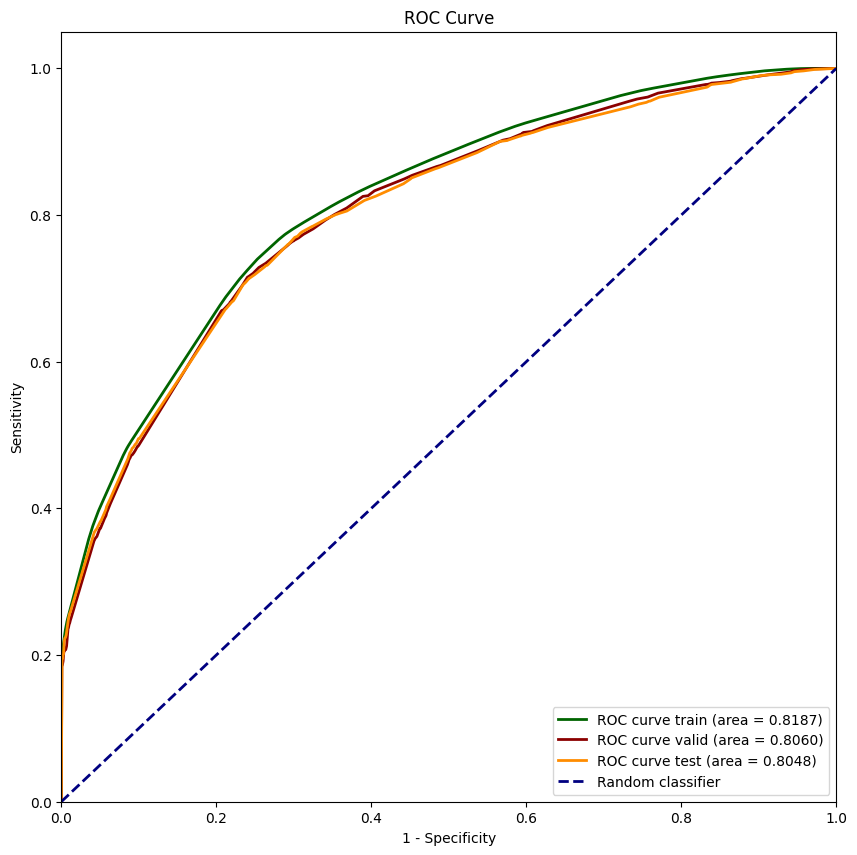

In [154]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred_test = best_clf.predict(X_test)

print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_test)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_test)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_test)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred_test)))
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_test)))

# roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred_train = best_clf.predict_proba(X_train)[:, 1]
y_pred_valid = best_clf.predict_proba(X_valid)[:, 1]
y_pred_test = best_clf.predict_proba(X_test)[:, 1]
fprr, tprr, thresholdsr = roc_curve(y_train, y_pred_train)
fprv, tprv, thresholdsv = roc_curve(y_valid, y_pred_valid)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_aucr = auc(fprr, tprr)
roc_aucv = auc(fprv, tprv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fprr, tprr, color='darkgreen', lw=2, label='ROC curve train (area = {:.4f})'.format(roc_aucr))
plt.plot(fprv, tprv, color='darkred', lw=2, label='ROC curve valid (area = {:.4f})'.format(roc_aucv))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve test (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

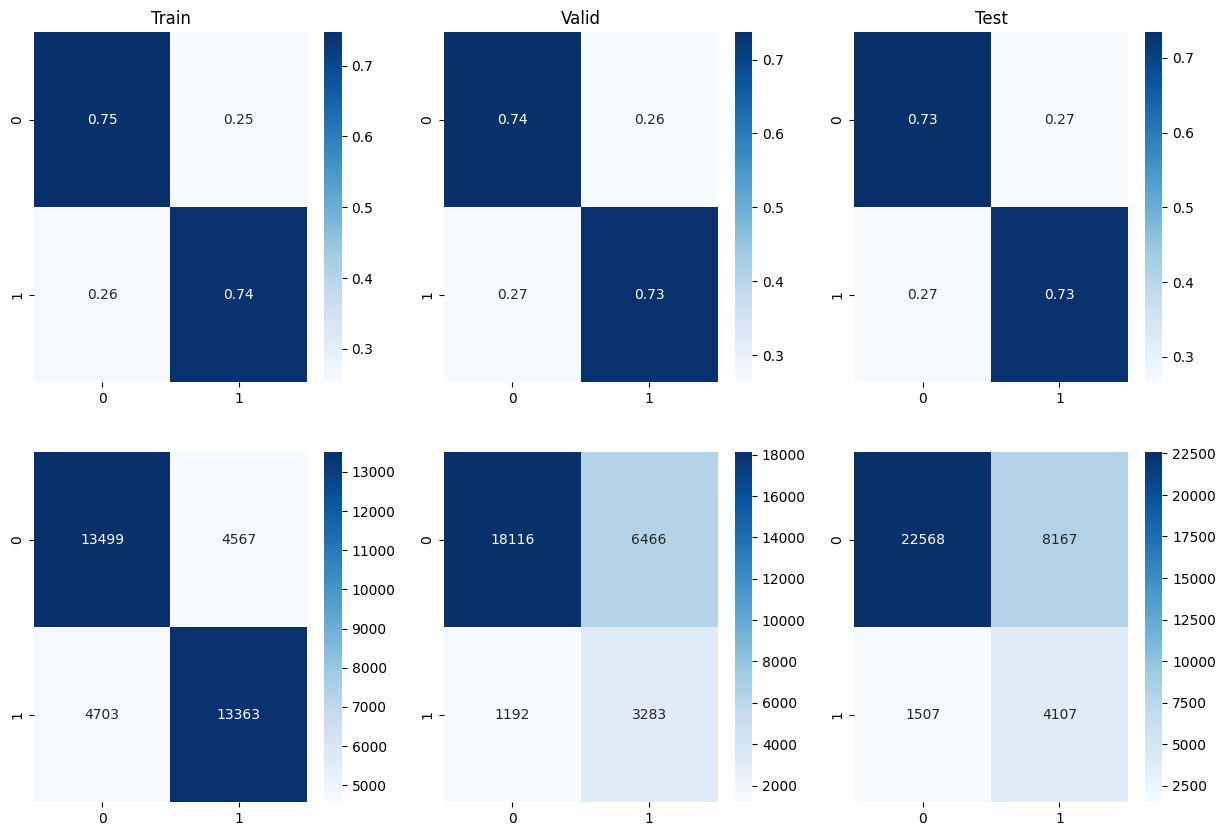

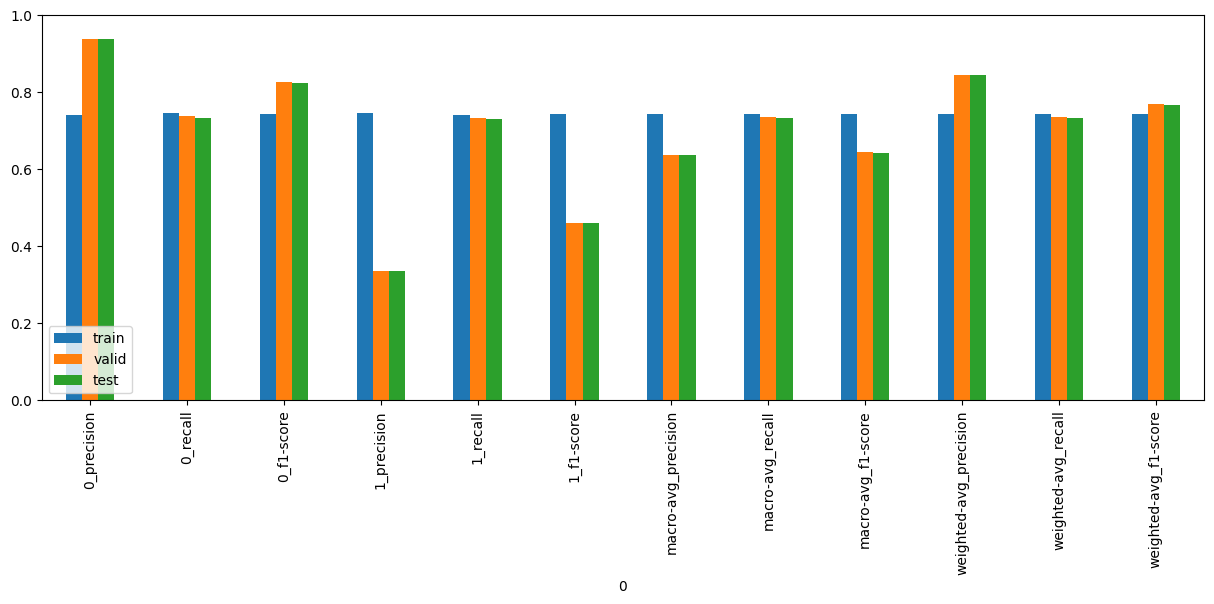

In [164]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def writable(class_report, base_key = '', separator = '_'):
    for key, value in class_report.items():
        if isinstance(value, dict):
            yield from writable(value, key)
        else:
            yield str(base_key + separator + key).replace(' ', '-'), value

y_pred_train = best_clf.predict(X_train)
y_pred_valid = best_clf.predict(X_valid)
y_pred_test = best_clf.predict(X_test)

# Confusion matrices
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0][0].set_title('Train')
axs[0][1].set_title('Valid')
axs[0][2].set_title('Test')
sns.heatmap(confusion_matrix(y_train, y_pred_train, normalize='true'), annot=True, ax=axs[0][0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid, normalize='true'), annot=True, ax=axs[0][1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test, normalize='true'), annot=True, ax=axs[0][2], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d' , ax=axs[1][0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, fmt='d', ax=axs[1][1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', ax=axs[1][2], cmap = 'Blues')
plt.show()

from sklearn.metrics import classification_report
# Scores
fig, ax = plt.subplots(figsize=(15, 5))
tr_cr = pd.DataFrame(writable(classification_report(y_train, y_pred_train, labels=[0, 1], output_dict=True), 'train'), columns=['0', 'train'])
tr_cr.set_index('0', inplace=True)
va_cr = pd.DataFrame(writable(classification_report(y_valid, y_pred_valid, labels=[0, 1], output_dict=True), 'valid'), columns=['0', 'valid'])
va_cr.set_index('0', inplace=True)
te_cr = pd.DataFrame(writable(classification_report(y_test, y_pred_test, labels=[0, 1], output_dict=True), 'test'), columns=['0', 'test'])
te_cr.set_index('0', inplace=True)

trvate = tr_cr.merge(va_cr, left_index=True, right_index=True)
trvate = trvate.merge(te_cr, left_index=True, right_index=True)

# remove all rows where index contains 'support'
trvate = trvate[~trvate.index.str.contains('support')]

trvate.plot.bar(ax=ax)
plt.ylim(0, 1)
plt.legend(loc='lower left')
plt.show()

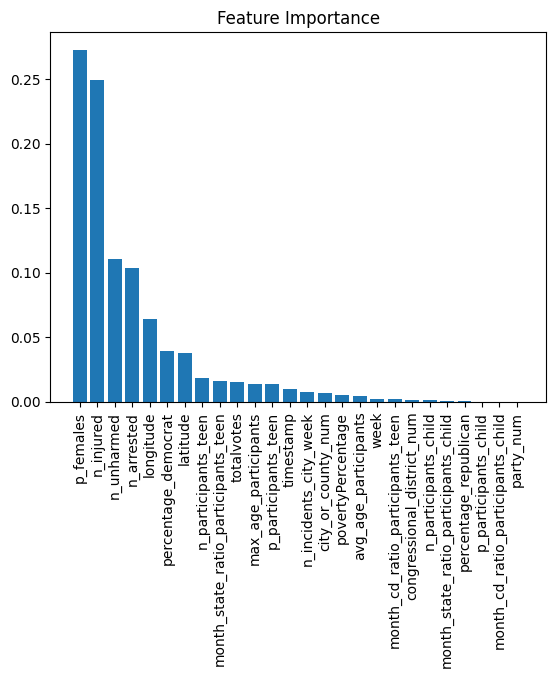

In [146]:
importances = best_clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)

plt.show()

In [147]:
from sklearn.tree import export_graphviz

import pydotplus

# from IPython.display import Image
dot_data = export_graphviz(best_clf, out_file=None, feature_names=X_train.columns, class_names=['Not_Killed', 'Killed'], filled=True, rounded=True, special_characters=True, max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('graph.png')

True

## Bruteforce

/tmp/ipykernel_3365/674461997.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weight = {0: train_vc[1] / train_vc[0], 1: 1}


0.9721274938911415
0.7184395142623126
[[107183   4540]
 [  1688 110035]]
[[24789  3292]
 [12521 15560]]
              precision    recall  f1-score   support

           0       0.66      0.88      0.76     28081
           1       0.83      0.55      0.66     28081

    accuracy                           0.72     56162
   macro avg       0.74      0.72      0.71     56162
weighted avg       0.74      0.72      0.71     56162



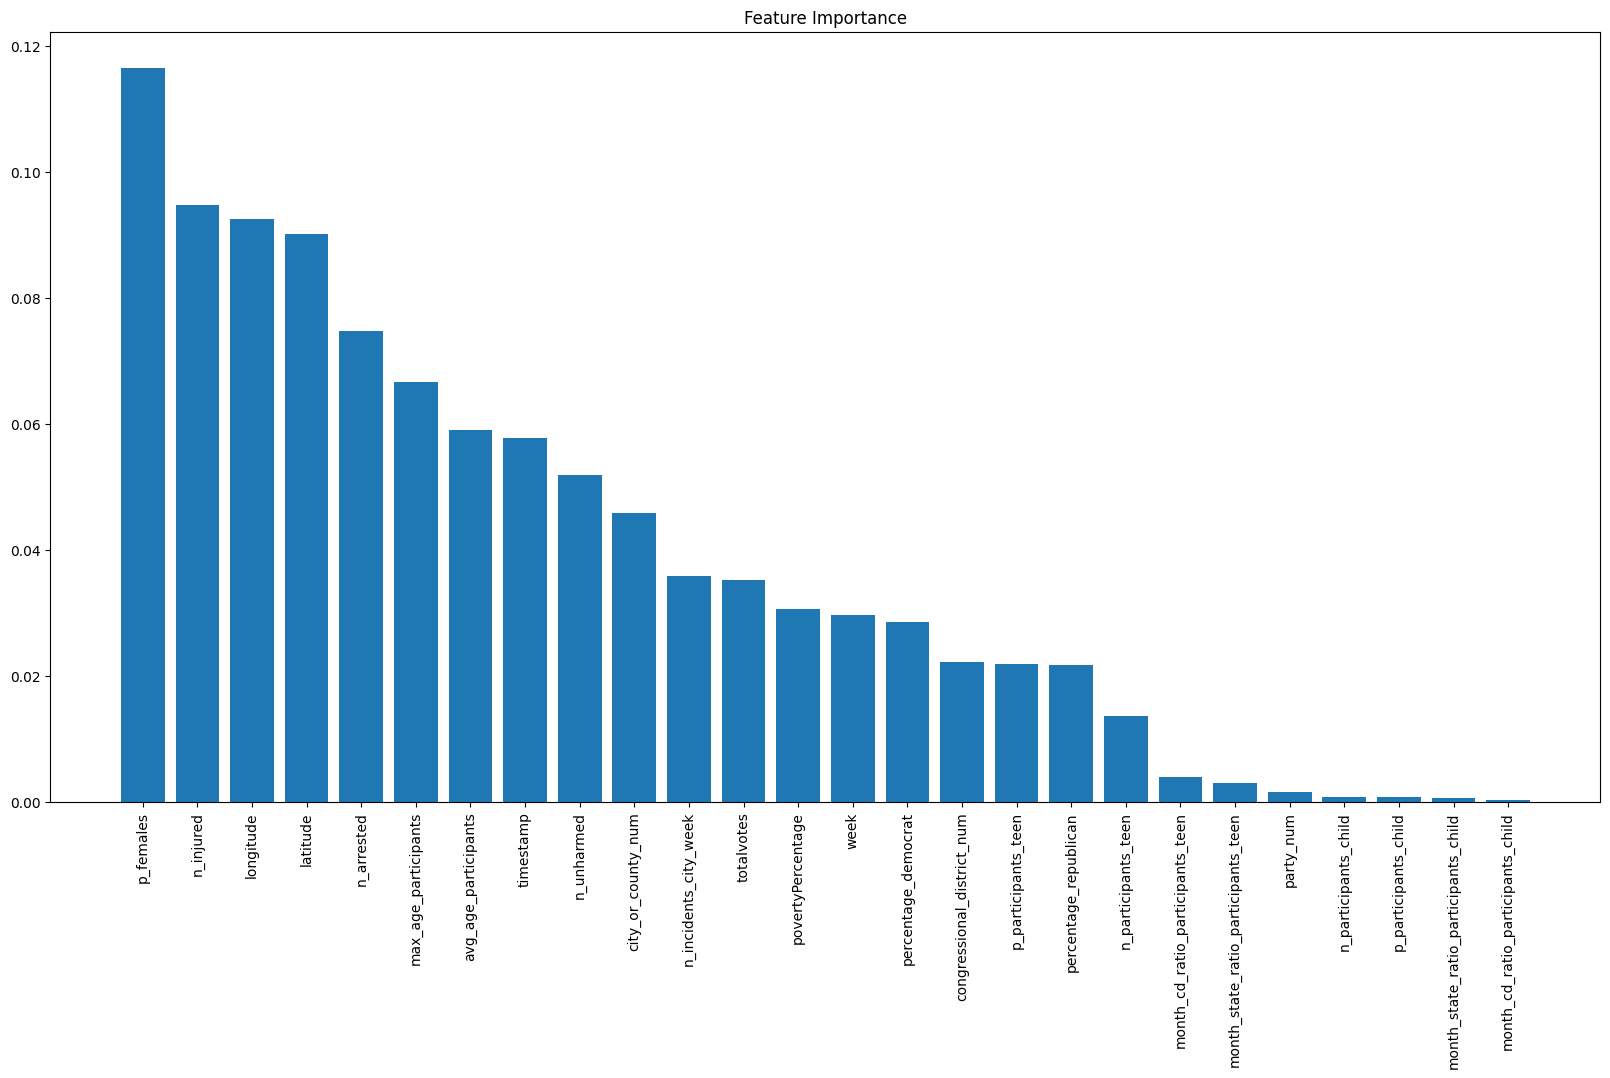

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

train_vc = y_train.value_counts()
class_weight = {0: train_vc[1] / train_vc[0], 1: 1}

clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=80, min_samples_split=3, min_samples_leaf=4, class_weight=class_weight)

clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_valid)
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_valid, y_pred))
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, y_pred_train, labels=[0, 1]))
print(confusion_matrix(y_valid, y_pred, labels=[0, 1]))

from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred, labels=[0, 1]))

from matplotlib import pyplot as plt

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(20, 10))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()


In [43]:
from sklearn.tree import export_graphviz

import pydotplus

# from IPython.display import Image
dot_data = export_graphviz(clf, out_file=None, feature_names=X_train.columns, class_names=['Not_Killed', 'Killed'], filled=True, rounded=True, special_characters=True, max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('graph.png')

True

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=20, min_samples_split=3, min_samples_leaf=4, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_valid)
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_valid, y_pred))

print(confusion_matrix(y_train, y_pred_train, labels=[0, 1]))
print(confusion_matrix(y_valid, y_pred, labels=[0, 1]))


In [ ]:
a = clf.feature_importances_
b = X_train.columns
c = pd.DataFrame(a, index=b)
c.sort_values(by=0, ascending=False)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred, labels=[0, 1]))

# Neural network

## Batched

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_HIDDEN = 3
N_BATCH = 10

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(DEVICE)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(DEVICE)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).to(DEVICE)

input_size = X_train_tensor.shape[1]
hidden_size = 2 ** N_HIDDEN
output_size = 1

loss_function = nn.MSELoss()

learning_rate = 1e-3

model_params = [
    nn.Linear(input_size, hidden_size),
]

last_hidden_size = hidden_size
for i in range(1, N_HIDDEN):
    this_hidden_size = hidden_size // (2 ** i)
    model_params += [
        nn.Sigmoid(),
        nn.Linear(last_hidden_size, this_hidden_size),
    ]
    last_hidden_size = this_hidden_size
model_params += [
    nn.Softmax(dim=output_size),
]

from pprint import pprint
pprint(model_params)

model = nn.Sequential(*model_params).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

EPOCHS = 50000
losses = []
epochs = []
accs = []
accs_valid = []

model.train()
for epoch in range(EPOCHS):
    try:
        optimizer.zero_grad()
        X_perm = torch.randperm(X_train_tensor.size()[0])
        X_batches = torch.split(X_train_tensor[X_perm][X_train_tensor.shape[0] % N_BATCH:], int((y_train.shape[0] / N_BATCH)))
        y_batches = torch.split(y_train_tensor[X_perm][y_train_tensor.shape[0] % N_BATCH:], int((y_train.shape[0] / N_BATCH)))

        batch_losses = []
        
        if epoch % 100 == 0:
            acc_batch = []
        else:
            acc_batch = None

        for i in range(len(X_batches)):
            
            y_pred = model(X_batches[i])[:, 1]
            if acc_batch is not None:
                acc_batch.append(f1_score(y_batches[i].detach().cpu().numpy(), np.where(y_pred.detach().cpu() > 0.5, 1, 0)))
            loss = loss_function(y_pred, y_batches[i])
            batch_losses.append(loss.item())
            loss.backward()
        losses.append(np.mean(batch_losses))
        if epoch % 100 == 0:
            acc = np.mean(acc_batch)
            accs.append(acc)
            y_pred_valid = model(X_valid_tensor)
            y_pred_valid = y_pred_valid.squeeze(1)[:, 1].unsqueeze(1)
            acc_valid = f1_score(y_valid_tensor.detach().cpu().numpy(), np.where(y_pred_valid.detach().cpu() > 0.5, 1, 0))
            accs_valid.append(acc_valid)
            print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {np.mean(losses[-100:]):.4f}, F1: {acc:.4f}, valid F1: {acc_valid:.4f}')
        optimizer.step()
    except KeyboardInterrupt:
        break

from sklearn.metrics import confusion_matrix

# Convert the valid data to PyTorch tensors and get the predicted class
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(DEVICE)
y_pred_tensor = model(X_valid_tensor)[:, 1].unsqueeze(1).detach().cpu()

y_pred = np.where(y_pred_tensor > 0.5, 1, 0)

# _, y_pred = torch.max(y_pred_tensor, 1)

# # Print the confusion matrix
print(confusion_matrix(y_valid, y_pred))

# # Print the accuracy
from sklearn.metrics import f1_score
print(f1_score(y_valid, y_pred))

# plot the loss over the entire training procedure
plt.plot(losses)
plt.show()

plt.plot(accs, label='train')
plt.plot(accs_valid, label='valid')
plt.legend()
plt.show()


## Non-batched

[1. 1.]
[Linear(in_features=25, out_features=32, bias=True),
 Sigmoid(),
 Linear(in_features=32, out_features=16, bias=True),
 Sigmoid(),
 Linear(in_features=16, out_features=8, bias=True),
 Sigmoid(),
 Linear(in_features=8, out_features=4, bias=True),
 Sigmoid(),
 Linear(in_features=4, out_features=2, bias=True),
 Softmax(dim=1)]
Epoch 1/50000, Loss: 1199595.8750, F1: 0.0000, valid F1: 0.0000
Epoch 101/50000, Loss: 1198934.3750, F1: 0.6058, valid F1: 0.6059
Epoch 201/50000, Loss: 1195491.1250, F1: 0.6516, valid F1: 0.6600
Epoch 301/50000, Loss: 1192857.5000, F1: 0.6801, valid F1: 0.6891
Epoch 401/50000, Loss: 1190482.2500, F1: 0.6955, valid F1: 0.7056
Epoch 501/50000, Loss: 1188060.8750, F1: 0.7233, valid F1: 0.7270
Epoch 601/50000, Loss: 1186591.5000, F1: 0.7394, valid F1: 0.7406
Epoch 701/50000, Loss: 1185637.0000, F1: 0.7541, valid F1: 0.7530
Epoch 801/50000, Loss: 1184842.2500, F1: 0.7644, valid F1: 0.7598
Epoch 901/50000, Loss: 1184183.5000, F1: 0.7718, valid F1: 0.7615
Epoch 100

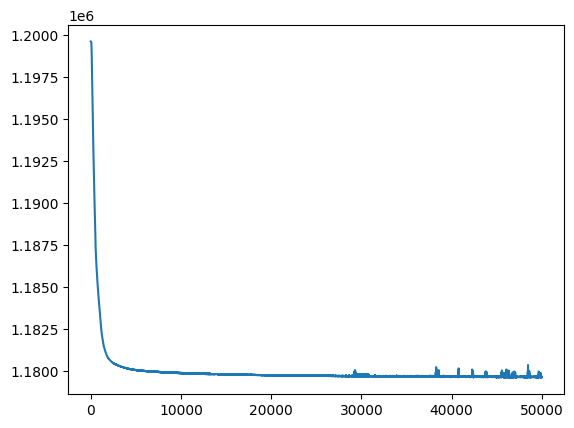

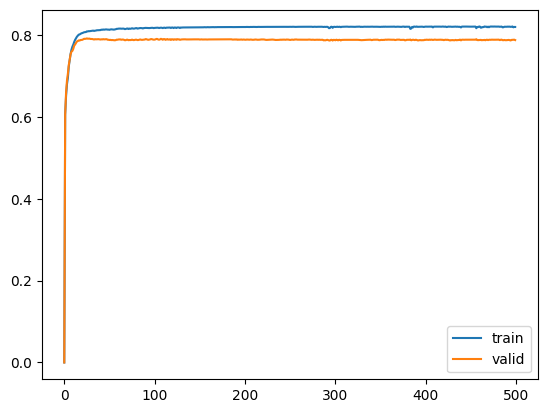

In [234]:
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
from sklearn.metrics import f1_score

writer = SummaryWriter()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(DEVICE)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(DEVICE)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).to(DEVICE)

input_size = X_train_tensor.shape[1]
N_HIDDEN = 5
BASE = 2
hidden_size = BASE ** N_HIDDEN
output_size = 1

# loss_function = nn.MSELoss()

# calculate class_weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print(class_weights)
weights = np.where(y_train == 1, class_weights[1], class_weights[0])
weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE)

loss_function = nn.CrossEntropyLoss(weight=weights)

learning_rate = 1e-3

model_params = [
    nn.Linear(input_size, hidden_size),
]

last_hidden_size = hidden_size
for i in range(1, N_HIDDEN):
    this_hidden_size = hidden_size // (BASE ** i)
    model_params += [
        nn.Sigmoid(),
        # nn.Dropout(0.1),
        nn.Linear(last_hidden_size, this_hidden_size),
    ]
    last_hidden_size = this_hidden_size
model_params += [
    nn.Softmax(dim=output_size),
]

from pprint import pprint
pprint(model_params)

model = nn.Sequential(*model_params).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

EPOCHS = 50000
losses = []
epochs = []
accs = []
accs_valid = []

model.train()
for epoch in range(EPOCHS):
    try:
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)[:, 1]
        loss = loss_function(y_pred, y_train_tensor)
        writer.add_scalar('Loss/train', loss.item(), epoch)
        losses.append(loss.item())
        if epoch % 100 == 0:
            acc = f1_score(y_train_tensor.detach().cpu().numpy(), np.where(y_pred.detach().cpu() > 0.5, 1, 0))
            accs.append(acc)
            y_pred_valid = model(X_valid_tensor)
            y_pred_valid = y_pred_valid.squeeze(1)[:, 1].unsqueeze(1)
            acc_valid = f1_score(y_valid_tensor.detach().cpu().numpy(), np.where(y_pred_valid.detach().cpu() > 0.5, 1, 0))
            accs_valid.append(acc_valid)
            print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}, F1: {acc:.4f}, valid F1: {acc_valid:.4f}')
            writer.add_scalar('F1/train', acc, epoch)
            writer.add_scalar('F1/valid', acc_valid, epoch)
        loss.backward()
        optimizer.step()
    except KeyboardInterrupt:
        break

from sklearn.metrics import confusion_matrix

# Convert the valid data to PyTorch tensors and get the predicted class
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(DEVICE)
y_pred_tensor = model(X_valid_tensor)[:, 1].unsqueeze(1).detach().cpu()

y_pred = np.where(y_pred_tensor > 0.5, 1, 0)

# _, y_pred = torch.max(y_pred_tensor, 1)

# # Print the confusion matrix
print(confusion_matrix(y_valid, y_pred))

# # Print the accuracy
from sklearn.metrics import f1_score
print(f1_score(y_valid, y_pred))

# plot the loss over the entire training procedure
plt.plot(losses)
plt.show()

plt.plot(accs, label='train')
plt.plot(accs_valid, label='valid')
plt.legend()
plt.show()


## Results

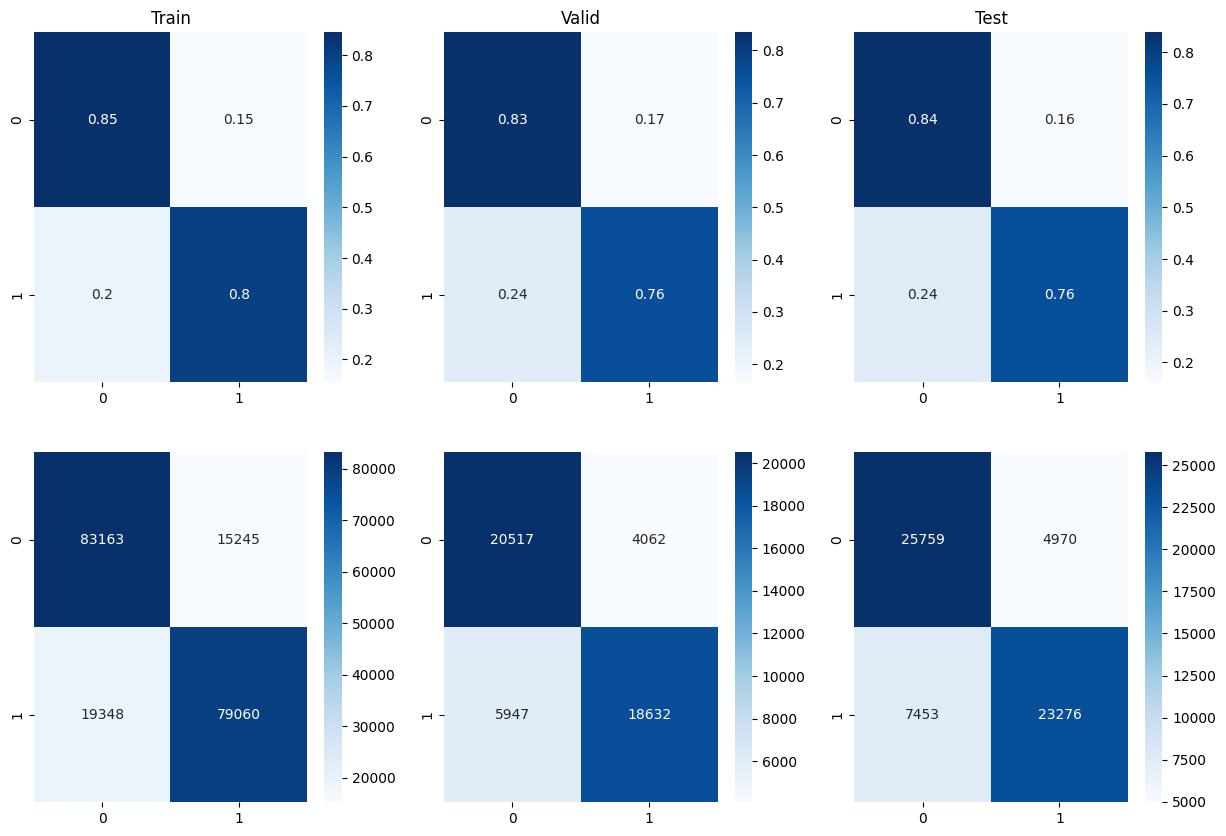

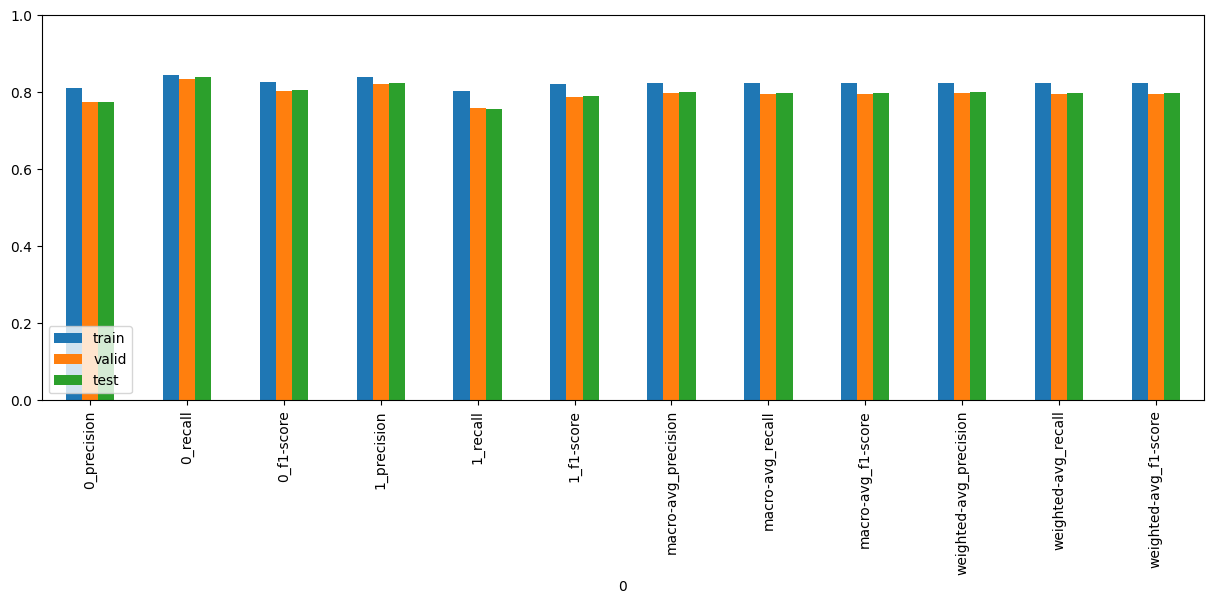

In [235]:
import seaborn as sns

def writable(class_report, base_key = '', separator = '_'):
    for key, value in class_report.items():
        if isinstance(value, dict):
            yield from writable(value, key)
        else:
            yield str(base_key + separator + key).replace(' ', '-'), value

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE)

y_pred_train = np.where(model(X_train_tensor).detach().cpu() > .5, 1, 0)[:, 1]
y_pred_valid = np.where(model(X_valid_tensor).detach().cpu() > .5, 1, 0)[:, 1]
y_pred_test  = np.where(model(X_test_tensor).detach().cpu()  > .5, 1, 0)[:, 1]

# Confusion matrices
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0][0].set_title('Train')
axs[0][1].set_title('Valid')
axs[0][2].set_title('Test')
sns.heatmap(confusion_matrix(y_train, y_pred_train, normalize='true'), annot=True, ax=axs[0][0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid, normalize='true'), annot=True, ax=axs[0][1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test, normalize='true'), annot=True, ax=axs[0][2], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', ax=axs[1][0], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, fmt='d', ax=axs[1][1], cmap = 'Blues')
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', ax=axs[1][2], cmap = 'Blues')
plt.show()

from sklearn.metrics import classification_report
# Scores
fig, ax = plt.subplots(figsize=(15, 5))
tr_cr = pd.DataFrame(writable(classification_report(y_train, y_pred_train, labels=[0, 1], output_dict=True), 'train'), columns=['0', 'train'])
tr_cr.set_index('0', inplace=True)
va_cr = pd.DataFrame(writable(classification_report(y_valid, y_pred_valid, labels=[0, 1], output_dict=True), 'valid'), columns=['0', 'valid'])
va_cr.set_index('0', inplace=True)
te_cr = pd.DataFrame(writable(classification_report(y_test, y_pred_test, labels=[0, 1], output_dict=True), 'test'), columns=['0', 'test'])
te_cr.set_index('0', inplace=True)

trvate = tr_cr.merge(va_cr, left_index=True, right_index=True)
trvate = trvate.merge(te_cr, left_index=True, right_index=True)

# remove all rows where index contains 'support'
trvate = trvate[~trvate.index.str.contains('support')]

trvate.plot.bar(ax=ax)
plt.ylim(0, 1)
plt.legend(loc='lower left')
plt.show()

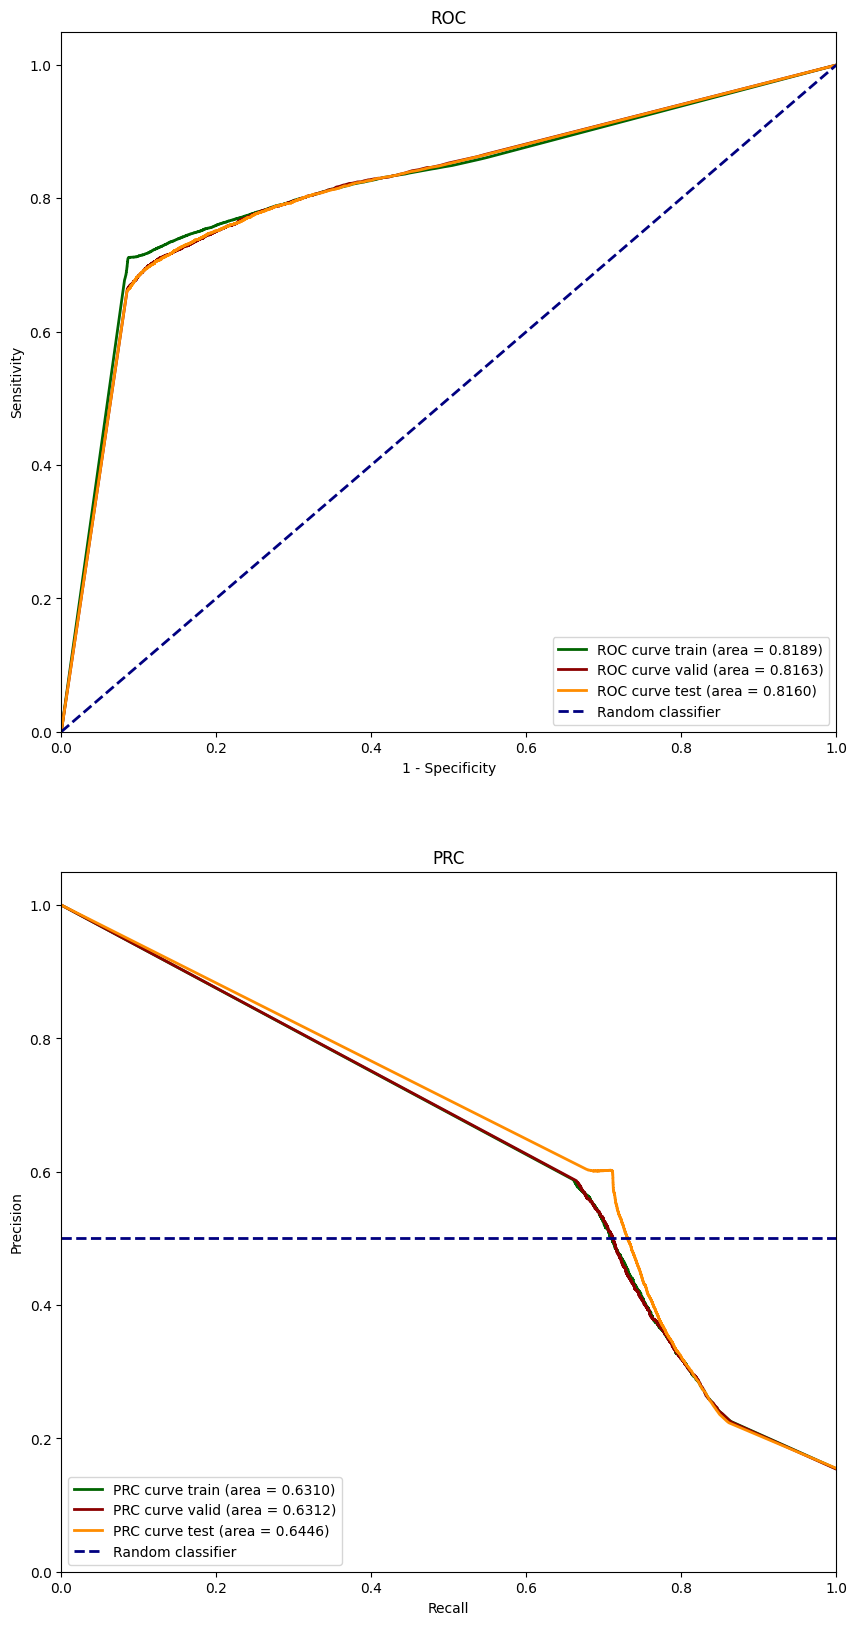

In [232]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_train = model(X_train_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()
y_pred_train = np.where(y_pred_train > 0.5, 1, 0)
y_pred_valid = model(X_valid_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()
y_pred_valid = np.where(y_pred_valid > 0.5, 1, 0)
y_pred_test = model(X_test_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()
y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

# roc curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
y_pred_train = model(X_train_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()
y_pred_valid = model(X_valid_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()
y_pred_test = model(X_test_tensor)[:, 1].unsqueeze(1).detach().cpu().squeeze(1).numpy()


fprr, tprr, thresholdsr = roc_curve(y_train, y_pred_train)
fprv, tprv, thresholdsv = roc_curve(y_valid, y_pred_valid)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

roc_aucr = auc(fprr, tprr)
roc_aucv = auc(fprv, tprv)
roc_auc = auc(fpr, tpr)


precr, recr, _ = precision_recall_curve(y_test, y_pred_test)
precv, recv, _ = precision_recall_curve(y_valid, y_pred_valid)
prect, rect, _ = precision_recall_curve(y_train, y_pred_train)

prc_aucr = auc(recr, precr)
prc_aucv = auc(recv, precv)
prc_auc = auc(rect, prect)


fig, axs = plt.subplots(2, 1, figsize=(10, 20))
ax = axs[0]
ax.plot(fprr, tprr, color='darkgreen', lw=2, label='ROC curve train (area = {:.4f})'.format(roc_aucr))
ax.plot(fprv, tprv, color='darkred', lw=2, label='ROC curve valid (area = {:.4f})'.format(roc_aucv))
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve test (area = {:.4f})'.format(roc_auc))
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')
ax.set_title('ROC')
ax.legend(loc="lower right")

ax = axs[1]
ax.plot(recr, precr, color='darkgreen', lw=2, label='PRC curve train (area = {:.4f})'.format(prc_aucr))
ax.plot(recv, precv, color='darkred', lw=2, label='PRC curve valid (area = {:.4f})'.format(prc_aucv))
ax.plot(rect, prect, color='darkorange', lw=2, label='PRC curve test (area = {:.4f})'.format(prc_auc))
ax.plot([0, 1], [.5, .5], color='navy', lw=2, linestyle='--', label='Random classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('PRC')
ax.legend(loc="lower left")

plt.show()


# Explainers

In [ ]:
from lime.lime_tabular import LimeTabularExplainer


def descale(x):
    return scaler.inverse_transform(x)

def scale(x):
    return scaler.transform(x)

explainer = LimeTabularExplainer(X_train.values, training_labels=y_train, feature_names=X_train.columns, class_names=['Not_Killed', 'Killed'], discretize_continuous=True, discretizer='entropy', verbose=True)


# exp

In [ ]:
def predict_fn(x):
    x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
    c = model(x).detach().cpu().numpy()
    c = np.hstack([1 - c, c])
    return c


# exp = explainer.explain_instance(X_test.iloc[992], predict_fn, num_features=15)
exp = explainer.explain_instance(X_test.iloc[991], predict_fn, num_features=10)
# exp.save_to_file('exp.html')
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_list()




In [ ]:
import shap

X_test_sample = X_test.sample(10)
X_test_sample_tensor = torch.tensor(X_test_sample.values, dtype=torch.float32).to(DEVICE)

e = shap.DeepExplainer(model, X_train_tensor)
shap_values = e.shap_values(X_test_sample_tensor)

shap.summary_plot(shap_values, X_test_tensor, feature_names=X_test.columns, plot_type="bar")